<a href="https://colab.research.google.com/github/xhxuciedu/CS175/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pylab as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!nvidia-smi

Wed Mar  6 16:48:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    30W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100
batch_size = 100
sample_dir = 'samples'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                #transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                #                     std=(0.5, 0.5, 0.5))
            ])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)


In [0]:
tmp = iter(data_loader).next()

In [32]:
tmp[0][0,0].min(), tmp[0][0,0].max()

(tensor(0.), tensor(1.))

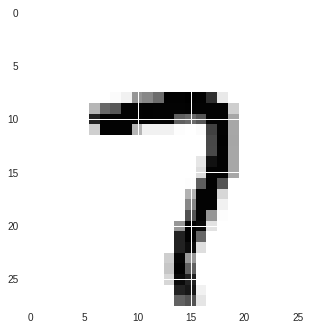

In [30]:
plt.imshow(tmp[0][0,0])

In [0]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Sigmoid())

# Device setting
D = D.to(device)
G = G.to(device)

In [0]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [88]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))


Epoch [0/100], Step [200/600], d_loss: 0.1008, g_loss: 5.1739, D(x): 0.96, D(G(z)): 0.03
Epoch [0/100], Step [400/600], d_loss: 0.0527, g_loss: 5.5509, D(x): 0.97, D(G(z)): 0.02
Epoch [0/100], Step [600/600], d_loss: 0.0076, g_loss: 6.4549, D(x): 1.00, D(G(z)): 0.01
Epoch [1/100], Step [200/600], d_loss: 0.0147, g_loss: 6.0750, D(x): 0.99, D(G(z)): 0.00
Epoch [1/100], Step [400/600], d_loss: 0.0037, g_loss: 7.6475, D(x): 1.00, D(G(z)): 0.00
Epoch [1/100], Step [600/600], d_loss: 0.0077, g_loss: 7.0799, D(x): 0.99, D(G(z)): 0.00
Epoch [2/100], Step [200/600], d_loss: 0.0053, g_loss: 6.8097, D(x): 1.00, D(G(z)): 0.00
Epoch [2/100], Step [400/600], d_loss: 0.0011, g_loss: 7.4233, D(x): 1.00, D(G(z)): 0.00
Epoch [2/100], Step [600/600], d_loss: 0.0028, g_loss: 6.8359, D(x): 1.00, D(G(z)): 0.00
Epoch [3/100], Step [200/600], d_loss: 0.0034, g_loss: 7.9104, D(x): 1.00, D(G(z)): 0.00
Epoch [3/100], Step [400/600], d_loss: 0.0040, g_loss: 6.9922, D(x): 1.00, D(G(z)): 0.00
Epoch [3/100], Step [

In [0]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [0]:
# generate images
z = torch.randn(10, latent_size).to(device)
fake_images = G(z)

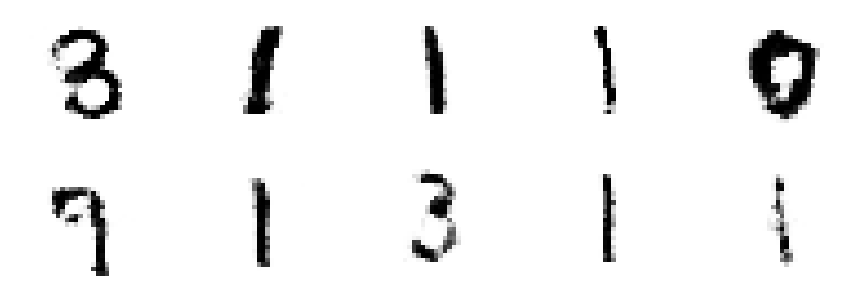

In [96]:
fig, ax = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
  ax[int(i/5), i%5].imshow(fake_images[i].view(28,28).cpu().detach().numpy())
  ax[int(i/5), i%5].axis('off')

In [79]:
i = 3
int(i/4), i%4

(0, 3)

In [42]:
import numpy as np
np.sqrt(784)

28.0

In [47]:
7%2, 7-2*(1%2)

(1, 5)